# **Investment Replica**

#### A machine learning approach to the problem

We start by importing the necessary libraries and reading the data.

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

df = pd.read_csv("InvestmentReplica.csv")
df.head()

,Date,MXWO,MXWD,LEGATRUU,HFRXGL,RX1,TY1,GC1,CO1,ES1,VG1,NQ1,LLL1,TP1,DU1,TU2
0,23/10/2007,1633.44,414.14,350.214,1343.63,113.70,110.516,759.0,82.85,1525.50,4393.0,2212.00,1287.0,1570.5,103.385,103.719
1,30/10/2007,1663.89,423.26,352.541,1356.53,113.79,110.656,787.8,87.44,1536.00,4476.0,2217.75,1323.9,1610.5,103.410,103.813
2,06/11/2007,1651.59,419.51,354.176,1360.20,113.79,110.875,823.4,93.26,1525.00,4425.0,2233.50,1320.0,1575.5,103.410,104.047
3,13/11/2007,1601.81,405.98,357.222,1347.16,114.35,111.719,799.0,88.83,1483.25,4323.0,2066.75,1271.0,1440.5,103.595,104.305
4,20/11/2007,1570.74,398.54,359.445,1335.21,114.72,113.156,791.4,95.49,1446.00,4296.0,2035.50,1225.2,1472.5,103.800,104.945


We also define a couple of useful functions, to transform data from returns to price and viceversa.
This is done to make the rest of the code more readable.

In [63]:
def price2ret(x):
    return x.pct_change()

def ret2price(x):
    return (1+x).cumprod()

### Data Visualization and Preprocessing

We plot the first four indexes to get a sense of the data.

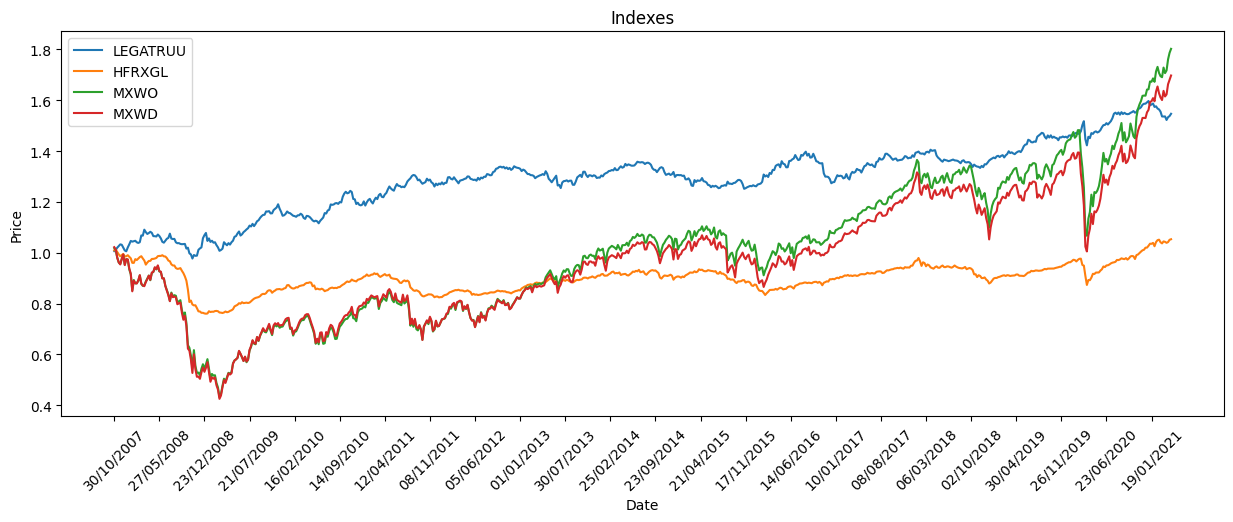

In [64]:
plt.figure(figsize=(15,5))
plt.plot(df['Date'][1:], df['LEGATRUU'][1:]/df['LEGATRUU'][0], label='LEGATRUU')
plt.plot(df['Date'][1:], df['HFRXGL'][1:]/df['HFRXGL'][0], label='HFRXGL')
plt.plot(df['Date'][1:], df['MXWO'][1:]/df['MXWO'][0], label='MXWO')
plt.plot(df['Date'][1:], df['MXWD'][1:]/df['MXWD'][0], label='MXWD')
plt.title('Indexes')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(df['Date'][1::30], rotation=45)
plt.show()

We define a target variable, as a combination of the three indexes, and we plot it against them.

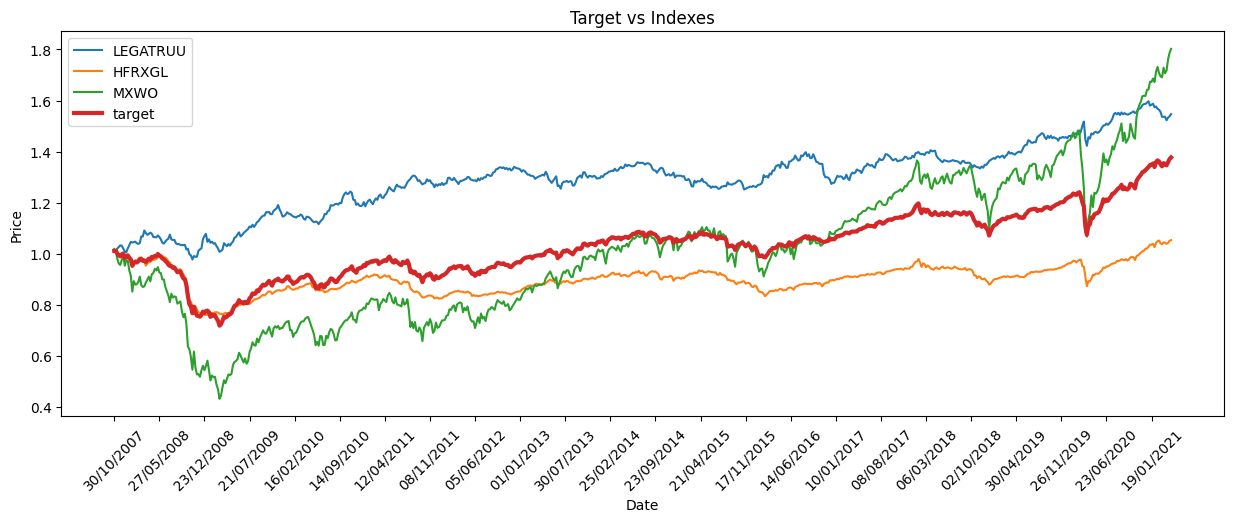

In [65]:
wHFRXGL = 0.5
wMXWO = 0.25
wLEGATRUU = 0.25

y = wHFRXGL*price2ret(df.HFRXGL) + wMXWO*price2ret(df.MXWO) + wLEGATRUU*price2ret(df.LEGATRUU)
target = (ret2price(y))
target = target.dropna()

plt.figure(figsize=(15,5))
plt.plot(df['Date'][1:], df['LEGATRUU'][1:]/df['LEGATRUU'][0], label='LEGATRUU')
plt.plot(df['Date'][1:], df['HFRXGL'][1:]/df['HFRXGL'][0], label='HFRXGL')
plt.plot(df['Date'][1:], df['MXWO'][1:]/df['MXWO'][0], label='MXWO')
plt.plot(df['Date'][1:], target, label='target',linewidth=3)
plt.title('Target vs Indexes')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(df['Date'][1::30], rotation=45)
plt.show()

We make a dataframe with the futures, and we plot them.

From the plot, we can see that the futures are eterogeneous, so a combination of them can probably replicate well the target variable.

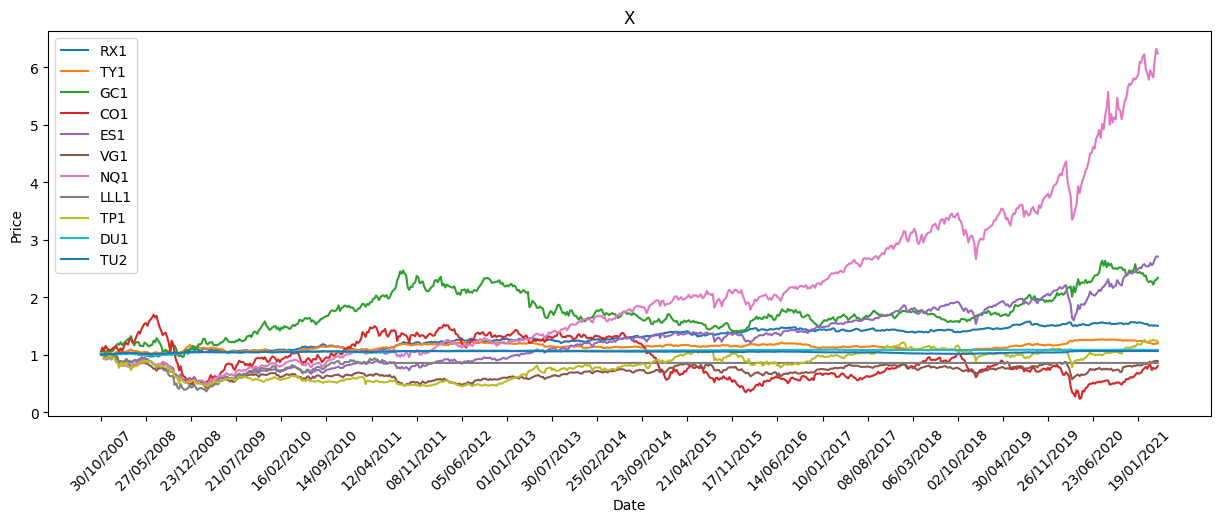

In [66]:
X = df[['RX1','TY1','GC1','CO1','ES1','VG1','NQ1','LLL1','TP1','DU1','TU2']]
X = price2ret(X)
X = X.dropna()

plt.figure(figsize=(15,5))
plt.plot(df['Date'][1:], ret2price(X.RX1), label='RX1')
plt.plot(df['Date'][1:], ret2price(X.TY1), label='TY1')
plt.plot(df['Date'][1:], ret2price(X.GC1), label='GC1')
plt.plot(df['Date'][1:], ret2price(X.CO1), label='CO1')
plt.plot(df['Date'][1:], ret2price(X.ES1), label='ES1')
plt.plot(df['Date'][1:], ret2price(X.VG1), label='VG1')
plt.plot(df['Date'][1:], ret2price(X.NQ1), label='NQ1')
plt.plot(df['Date'][1:], ret2price(X.LLL1), label='LLL1')
plt.plot(df['Date'][1:], ret2price(X.TP1), label='TP1')
plt.plot(df['Date'][1:], ret2price(X.DU1), label='DU1')
plt.plot(df['Date'][1:], ret2price(X.TU2), label='TU2')
plt.title('X')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(df['Date'][1::30], rotation=45)
plt.show()

X = ret2price(X)

It seems like LLL1 is constant after a certain point, so we verify it and remove it from the dataframe.
This is done because an abscence of variation probably means that the future is not traded anymore.

In [67]:
futures_const = []
for i in range(len(X.columns)):
    differences = X.iloc[:,i].diff()
    if differences[differences==0].shape[0] > 100:
        futures_const.append(X.columns[i])

print("the futures that are constant are: ", futures_const) 

X = X.drop(futures_const, axis=1)

the futures that are constant are:  ['LLL1']


Now we plot the correlation matrix of the futures, to see if there are any strong correlations. This will be useful to choose the reduced portfolios of the different "personas" that we will use in the app.

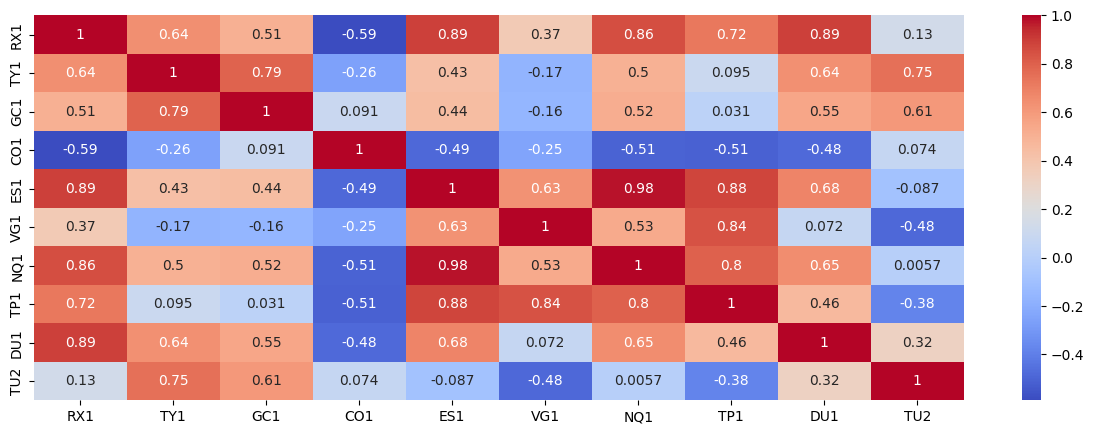

In [68]:
plt.figure(figsize=(15,5))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.show()

We also plot the distribution of the returns of the futures, to see if they are normal or not.

This will be useful mainly for the neural network, since it is a requirement for the model. For this reason, even if some futures are not perfectly normally distributed, they will be normalized only in the appendix file (where the neural network is implemented).

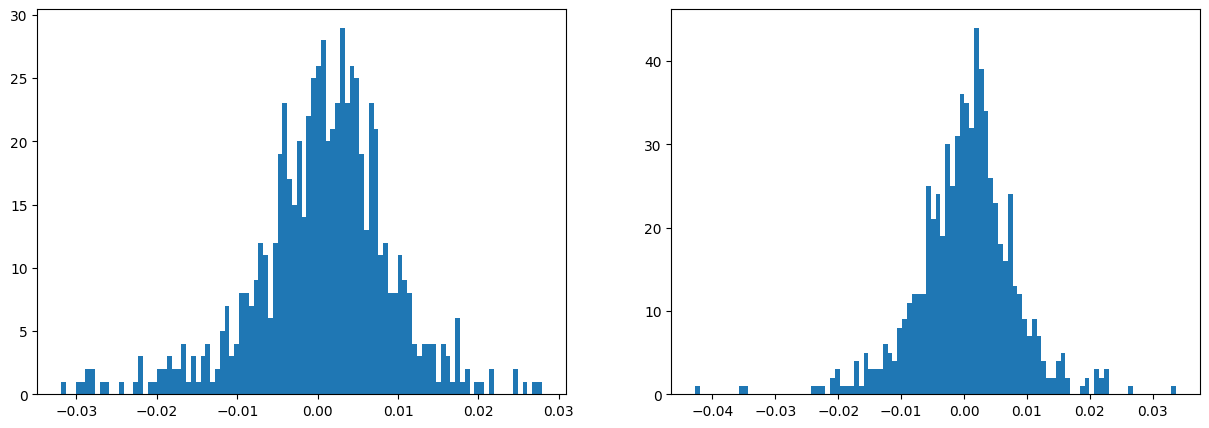

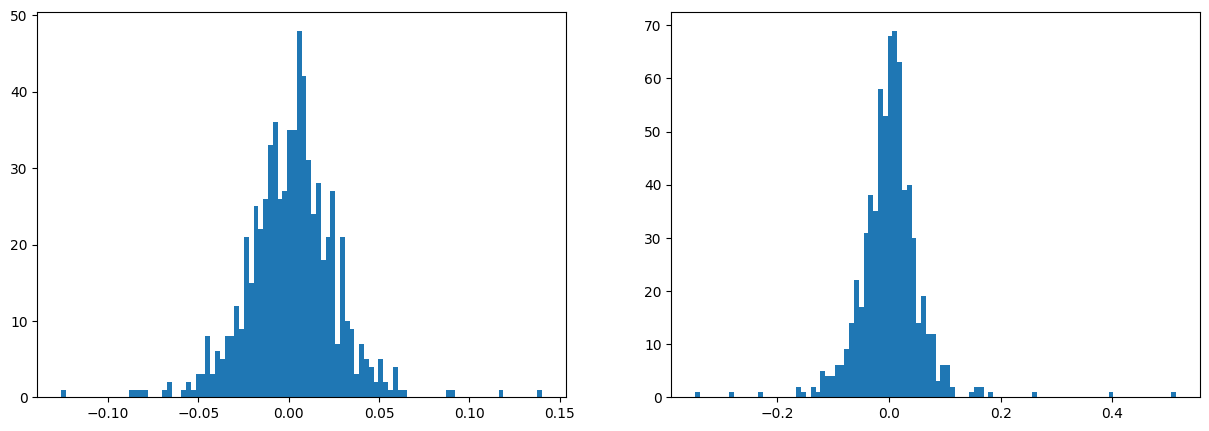

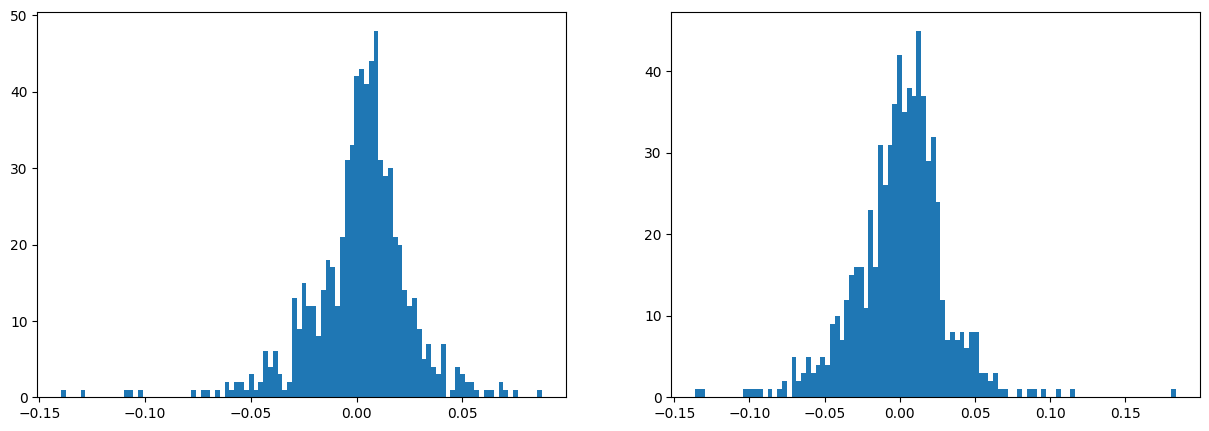

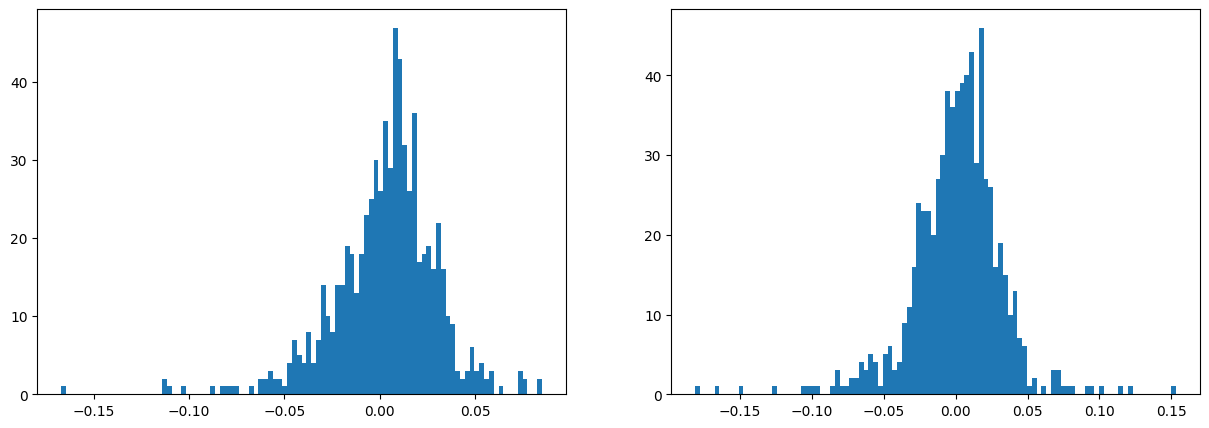

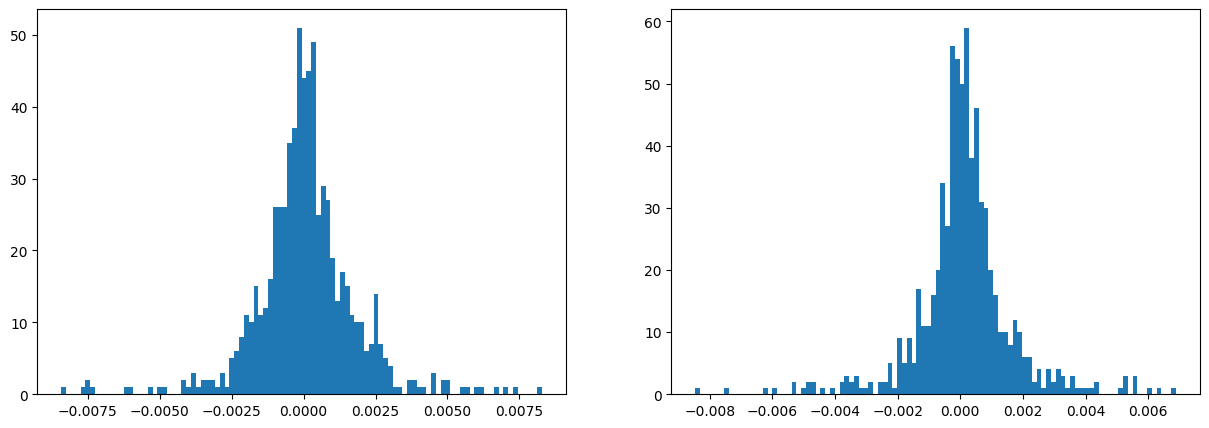

In [69]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(price2ret(X.RX1), bins=100)

plt.subplot(1,2,2)
plt.hist(price2ret(X.TY1), bins=100)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(price2ret(X.GC1), bins=100)

plt.subplot(1,2,2)
plt.hist(price2ret(X.CO1), bins=100)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(price2ret(X.ES1), bins=100)

plt.subplot(1,2,2)
plt.hist(price2ret(X.VG1), bins=100)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(price2ret(X.NQ1), bins=100)

plt.subplot(1,2,2)
plt.hist(price2ret(X.TP1), bins=100)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(price2ret(X.TU2), bins=100)

plt.subplot(1,2,2)
plt.hist(price2ret(X.DU1), bins=100)

plt.show()

For the selection of the "personas", we also look at the mean and standard deviation of the futures.

In [70]:
print("the mean of the futures are: ", X.mean())

print("the standard deviation of the futures are: ", X.std())

the mean of the futures are:  RX1    1.295748
TY1    1.140007
GC1    1.737413
CO1    0.929514
ES1    1.285520
VG1    0.698905
NQ1    2.048042
TP1    0.813019
DU1    1.066218
TU2    1.047394
dtype: float64
the standard deviation of the futures are:  RX1    0.169663
TY1    0.056758
GC1    0.360819
CO1    0.323626
ES1    0.505043
VG1    0.107335
NQ1    1.311760
TP1    0.225200
DU1    0.022852
TU2    0.014679
dtype: float64


Based on this various results, we selected three types of Portfolios for our simple app.

## *Models and results*

In all of this models, we will use a rolling window approach, with a window of 150 weeks, and a step of 1 week.

This allows us to have a realistic approach, as we will be able to test the models on data that they have never seen before.

We will also use a cross validation approach, with 5 folds, to avoid overfitting.

A model "testing phase" has been done on a toy dataset, to check which approaches made the most sense. A couple of these models will be presented in the "addendum" section, as they were not used in the final project, for various reasons.

### Lasso regression

We start using a **Lasso regression**, to see if we can get a good result with a relatively simple model.

In [71]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error

y_pred_Lasso = []
y_test_Lasso = []
weights_Lasso = []
gross_exposure_Lasso = []

for i in range(150, len(X)):
    lasso = LassoCV(cv=5, max_iter=100000,fit_intercept=False)
    lasso.fit(X[i-150:i], target[i-150:i])
    y_pred_Lasso.append(lasso.predict(X[i:i+1]))
    y_test_Lasso.append(target[i:i+1])
    weights_Lasso.append(lasso.coef_)
    gross_exposure_Lasso.append(np.sum(np.abs(lasso.coef_)))

We plot the predictions against the target variable.

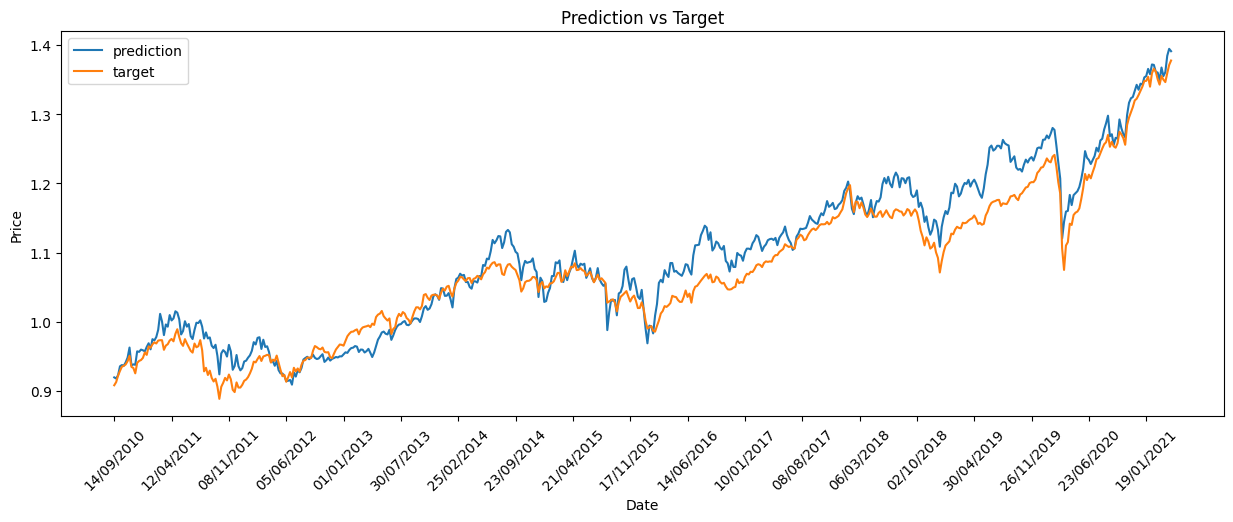

In [72]:
#plot the prediction versus the target
plt.figure(figsize=(15,5))
plt.plot(df['Date'][len(X)-len(y_pred_Lasso)+1:], y_pred_Lasso, label='prediction')
plt.plot(df['Date'][len(X)-len(y_pred_Lasso)+1:], y_test_Lasso, label='target')
plt.title('Prediction vs Target')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(df['Date'][len(X)-len(y_pred_Lasso)+1::30], rotation=45)
plt.show()

We compute various metrics, to see how well the model is performing.

We use both statistical metrics, such as the MSE, and financial metrics, such as the Tracking Error and the Gross Exposure.

In [73]:
MSE_Lasso = mean_squared_error(y_test_Lasso, y_pred_Lasso)
print('MSE:', MSE_Lasso)

tracking_error_Lasso = []
for i in range(len(y_pred_Lasso)):
    tracking_error_Lasso.append(y_test_Lasso[i] - y_pred_Lasso[i])

tracking_error_volatility_Lasso = np.std(tracking_error_Lasso)*np.sqrt(52)
print('Tracking Error Volatility:', tracking_error_volatility_Lasso)

information_ratio_Lasso = np.mean(tracking_error_Lasso)/tracking_error_volatility_Lasso
print('Information Ratio:', information_ratio_Lasso)

turnover_Lasso = []
d_weights_Lasso = np.diff(weights_Lasso, axis=0)
turnover_Lasso = np.sum(np.abs(d_weights_Lasso), axis=1) / 2
turnover_Lasso = turnover_Lasso.reshape(-1, 1)

mean_annual_turnover_Lasso = np.mean(turnover_Lasso)*52
print('Mean Annual Turnover:', mean_annual_turnover_Lasso)

tradingCosts = 0.0004
meanTradingCosts_Lasso = mean_annual_turnover_Lasso*tradingCosts
print('Mean Annual Trading Costs:', meanTradingCosts_Lasso)

MSE: 0.0009597087848349054
Tracking Error Volatility: 0.17577872471890915
Information Ratio: -0.10876404268713129
Mean Annual Turnover: 0.7203910781256442
Mean Annual Trading Costs: 0.0002881564312502577


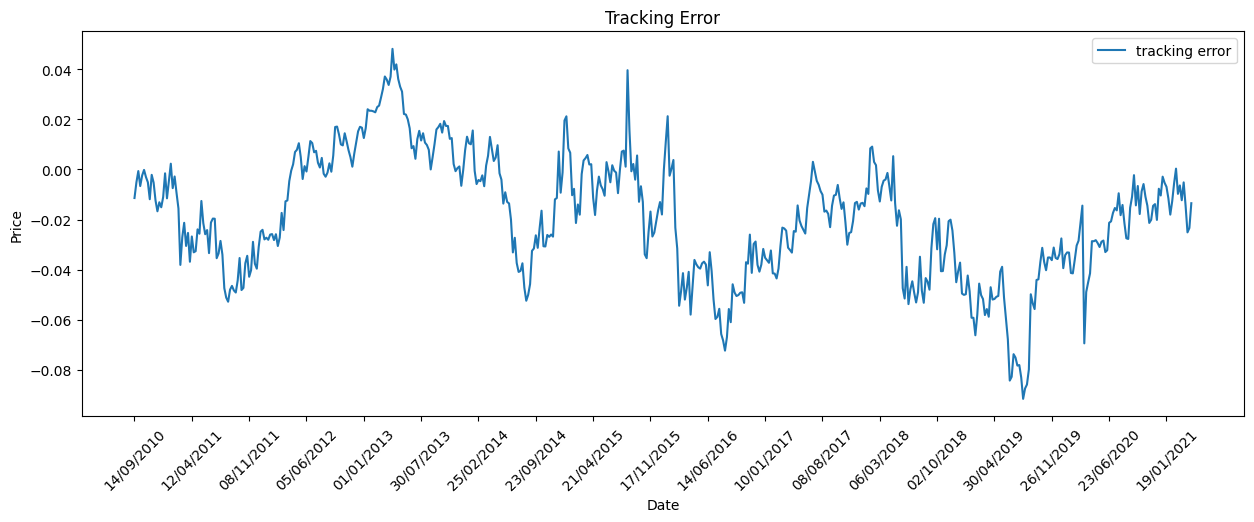

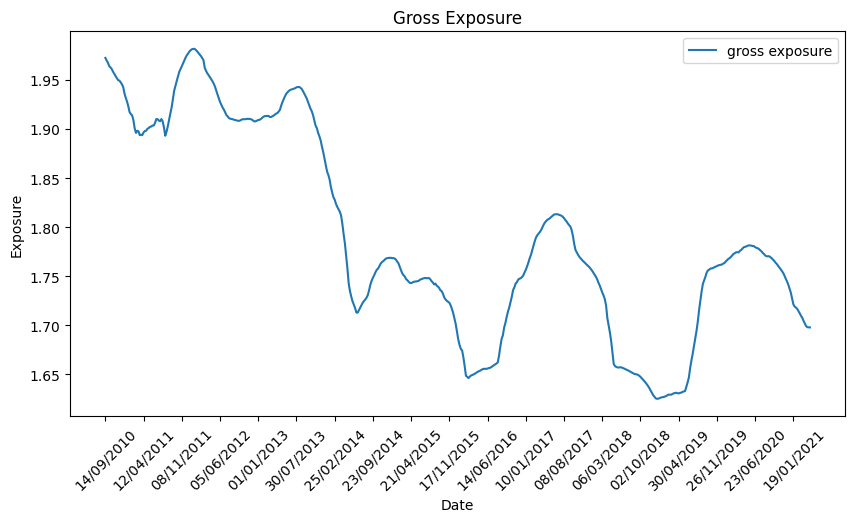

In [74]:
plt.figure(figsize=(15,5))
plt.plot(df['Date'][len(X)-len(y_pred_Lasso)+1:], tracking_error_Lasso, label='tracking error')
plt.title('Tracking Error')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(df['Date'][len(X)-len(y_pred_Lasso)+1::30], rotation=45)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(df['Date'][len(X)-len(y_pred_Lasso)+1:], gross_exposure_Lasso+np.ones(np.shape(gross_exposure_Lasso)), label='gross exposure')
plt.title('Gross Exposure')
plt.xlabel('Date')
plt.ylabel('Exposure')
plt.legend()
plt.xticks(df['Date'][len(X)-len(y_pred_Lasso)+1::30], rotation=45)
plt.show()


### Passive Aggressive Regressor

We try an approach based on the **Passive Aggressive Regressor**.

A pro of this model is that it is used in online learning, so the setting is similar to ours, getting data week by week.

A con, on the other hand, is that for accurate results it needs a lot of data, so it might not be the best choice for our problem.

In [75]:
from sklearn.linear_model import PassiveAggressiveRegressor

y_pred_PAR = []
y_test_PAR = []
weights_PAR = []
gross_exposure_PAR = []

for i in range(150, len(X)):
    model = PassiveAggressiveRegressor(fit_intercept=False)
    model.fit(X[i-150:i], target[i-150:i])
    y_pred_PAR.append(model.predict(X[i:i+1]))
    y_test_PAR.append(target[i:i+1])
    weights_PAR.append(model.coef_)
    gross_exposure_PAR.append(np.sum(np.abs(model.coef_)))


We plot the predictions against the target variable.

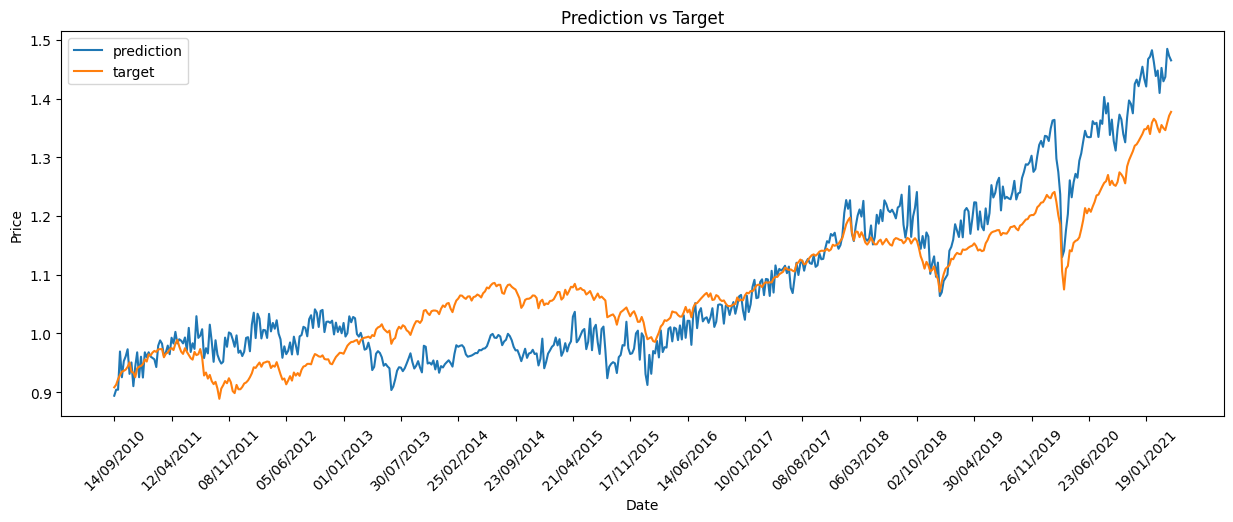

In [76]:
plt.figure(figsize=(15,5))
plt.plot(df['Date'][len(X)-len(y_pred_PAR)+1:], y_pred_PAR, label='prediction')
plt.plot(df['Date'][len(X)-len(y_pred_PAR)+1:], y_test_PAR, label='target')
plt.title('Prediction vs Target')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(df['Date'][len(X)-len(y_pred_PAR)+1::30], rotation=45)
plt.show()

We compute various metrics, to see how well the model is performing.

We use both statistical metrics, such as the MSE, and financial metrics, such as the Tracking Error and the Gross Exposure.

In [77]:
MSE_PAR = mean_squared_error(y_test_PAR, y_pred_PAR)
print('MSE:', MSE_PAR)

tracking_error_PAR = []
for i in range(len(y_pred_PAR)):
    tracking_error_PAR.append(y_test_PAR[i] - y_pred_PAR[i])

tracking_error_volatility_PAR = np.std(tracking_error_PAR)*np.sqrt(52)
print('Tracking Error Volatility:', tracking_error_volatility_PAR)

information_ratio_PAR = np.mean(tracking_error_PAR)/tracking_error_volatility_PAR
print('Information Ratio:', information_ratio_PAR)

turnover_PAR = []
d_weights_PAR = np.diff(weights_PAR, axis=0)
turnover_PAR = np.sum(np.abs(d_weights_PAR), axis=1) / 2
turnover_PAR = turnover_PAR.reshape(-1, 1)

mean_annual_turnover_PAR = np.mean(turnover_PAR)*52
print('Mean Annual Turnover:', mean_annual_turnover_PAR)

tradingCosts = 0.0004
meanTradingCosts_PAR = mean_annual_turnover_PAR*tradingCosts
print('Mean Annual Trading Costs:', meanTradingCosts_PAR)

MSE: 0.004240490571640751
Tracking Error Volatility: 0.4670842511845667
Information Ratio: -0.014355155377199481
Mean Annual Turnover: 1.5908628357250008
Mean Annual Trading Costs: 0.0006363451342900003


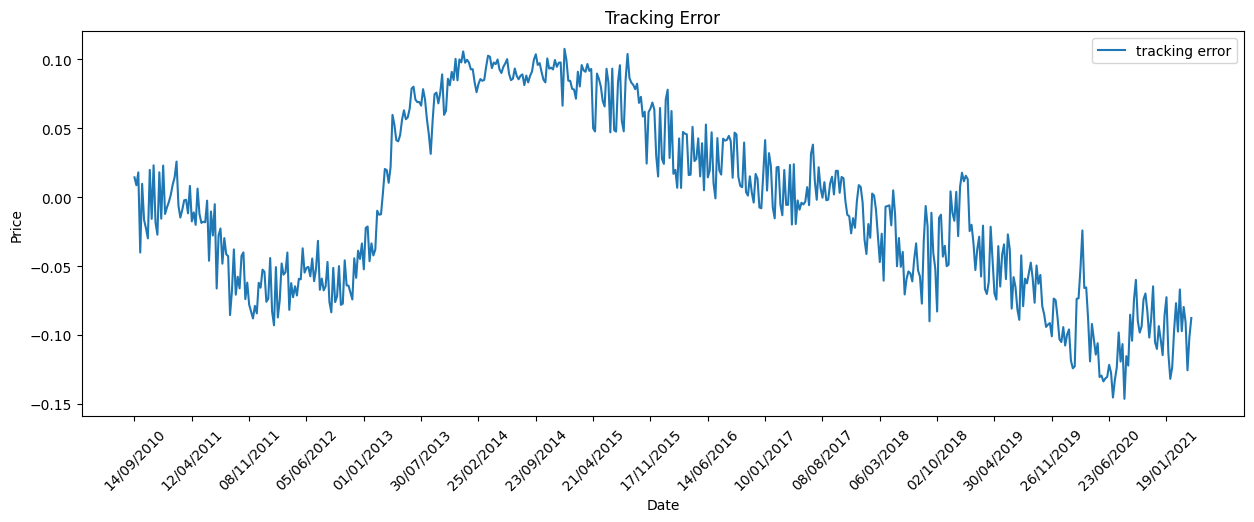

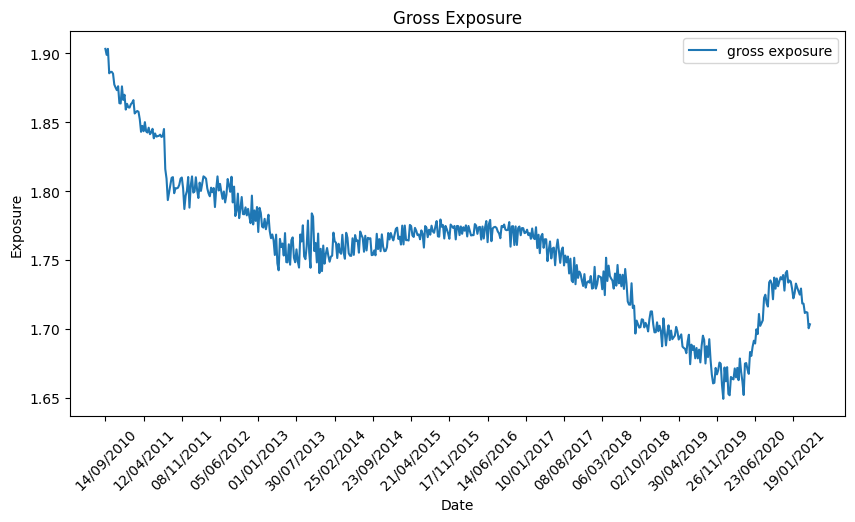

In [78]:
plt.figure(figsize=(15,5))
plt.plot(df['Date'][len(X)-len(y_pred_PAR)+1:], tracking_error_PAR, label='tracking error')
plt.title('Tracking Error')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(df['Date'][len(X)-len(y_pred_PAR)+1::30], rotation=45)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(df['Date'][len(X)-len(y_pred_PAR)+1:], gross_exposure_PAR+np.ones(np.shape(gross_exposure_PAR)), label='gross exposure')
plt.title('Gross Exposure')
plt.xlabel('Date')
plt.ylabel('Exposure')
plt.legend()
plt.xticks(df['Date'][len(X)-len(y_pred_PAR)+1::30], rotation=45)
plt.show()

### Stochastic Gradient Descent Regressor

We now try an approach based on the **Stochastic Gradient Descent Regressor**.

The advantages of this model are the efficiency and the ease of implementation.

The disadvantages are that it requires a few hyperparameters to be tuned for maximum effect, and that it is sensitive to feature scaling.

In [79]:
from sklearn.linear_model import SGDRegressor

y_pred_SGD = []
y_test_SGD = []
weights_SGD = []
gross_exposure_SGD = []

for i in range(150, len(X)):
    model = SGDRegressor(fit_intercept=False, average=True, penalty='l1')
    model.fit(X[i-150:i], target[i-150:i])
    y_pred_SGD.append(model.predict(X[i:i+1]))
    y_test_SGD.append(target[i:i+1])
    weights_SGD.append(model.coef_)
    gross_exposure_SGD.append(np.sum(np.abs(model.coef_)))

We plot the predictions against the target variable.

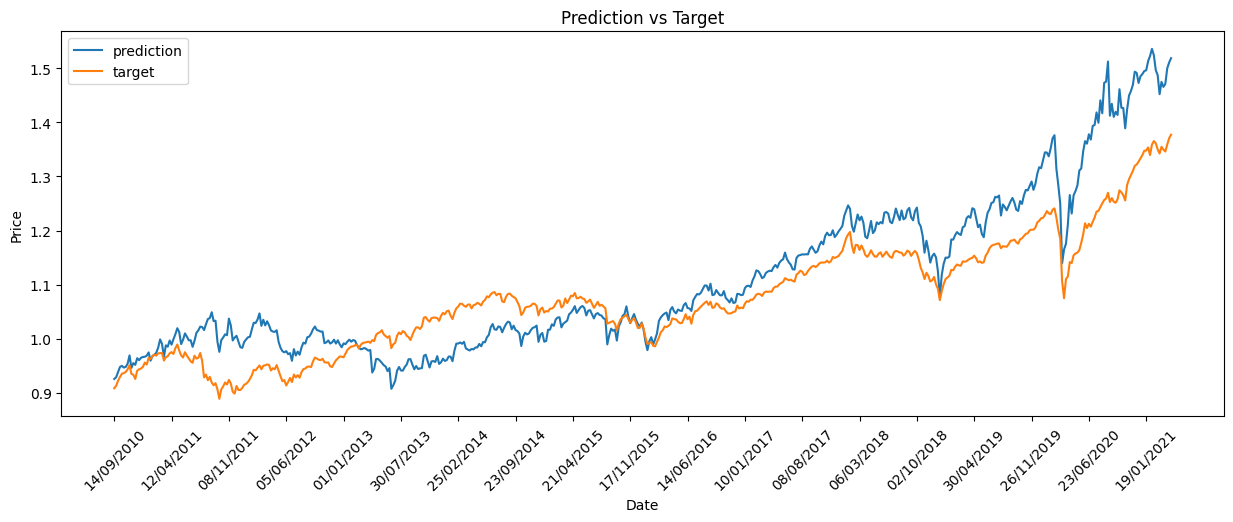

In [80]:
plt.figure(figsize=(15,5))
plt.plot(df['Date'][len(X)-len(y_pred_SGD)+1:], y_pred_SGD, label='prediction')
plt.plot(df['Date'][len(X)-len(y_pred_SGD)+1:], y_test_SGD, label='target')
plt.title('Prediction vs Target')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(df['Date'][len(X)-len(y_pred_SGD)+1::30], rotation=45)
plt.show()

We compute various metrics, to see how well the model is performing.

We use both statistical metrics, such as the MSE, and financial metrics, such as the Tracking Error and the Gross Exposure.

In [81]:
MSE_SGD = mean_squared_error(y_test_SGD, y_pred_SGD)
print('MSE:', MSE_SGD)

tracking_error_SGD = []
for i in range(len(y_pred_SGD)):
    tracking_error_SGD.append(y_test_SGD[i] - y_pred_SGD[i])

tracking_error_volatility_SGD = np.std(tracking_error_SGD)*np.sqrt(52)
print('Tracking Error Volatility:', tracking_error_volatility_SGD)

information_ratio_SGD = np.mean(tracking_error_SGD)/tracking_error_volatility_SGD
print('Information Ratio:', information_ratio_SGD)

turnover_SGD = []
d_weights_SGD = np.diff(weights_SGD, axis=0)
turnover_SGD = np.sum(np.abs(d_weights_SGD), axis=1) / 2
turnover_SGD = turnover_SGD.reshape(-1, 1)

mean_annual_turnover_SGD = np.mean(turnover_SGD)*52
print('Mean Annual Turnover:', mean_annual_turnover_SGD)

tradingCosts = 0.0004
meanTradingCosts_SGD = mean_annual_turnover_SGD*tradingCosts
print('Mean Annual Trading Costs:', meanTradingCosts_SGD)

MSE: 0.005196138582202633
Tracking Error Volatility: 0.4601365306150478
Information Ratio: -0.07287716245051876
Mean Annual Turnover: 0.40948696053371064
Mean Annual Trading Costs: 0.00016379478421348425


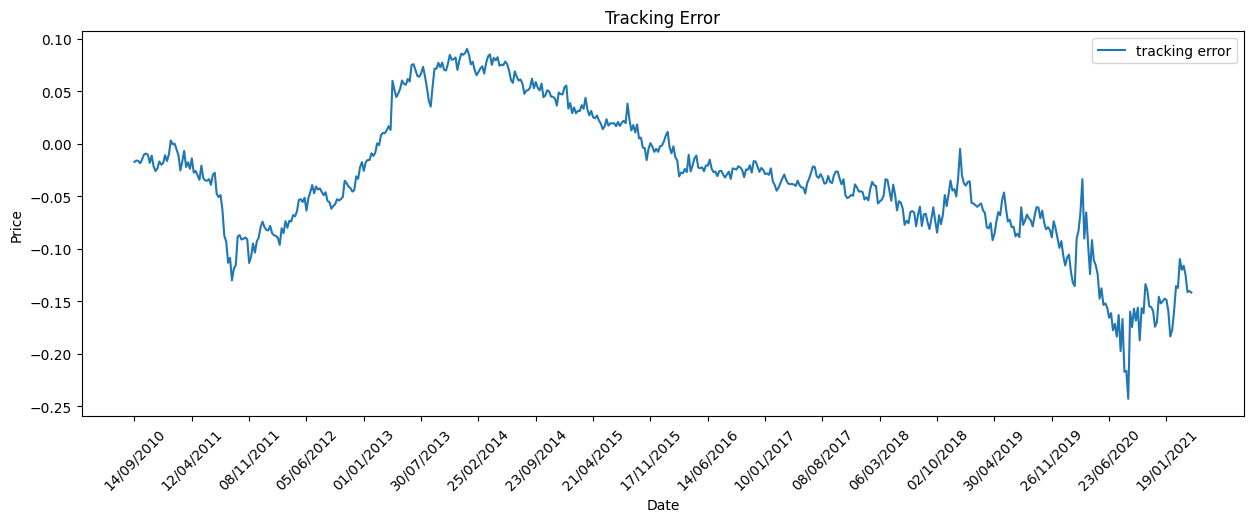

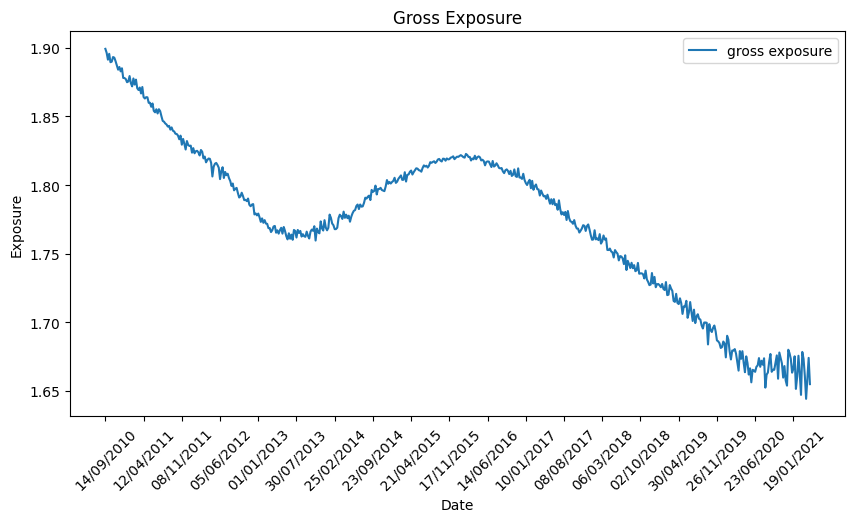

In [82]:
plt.figure(figsize=(15,5))
plt.plot(df['Date'][len(X)-len(y_pred_SGD)+1:], tracking_error_SGD, label='tracking error')
plt.title('Tracking Error')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(df['Date'][len(X)-len(y_pred_SGD)+1::30], rotation=45)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(df['Date'][len(X)-len(y_pred_SGD)+1:], gross_exposure_SGD+np.ones(np.shape(gross_exposure_SGD)), label='gross exposure')
plt.title('Gross Exposure')
plt.xlabel('Date')
plt.ylabel('Exposure')
plt.legend()
plt.xticks(df['Date'][len(X)-len(y_pred_SGD)+1::30], rotation=45)
plt.show()

### Elastic Net

We finally use an **Elastic Net** model.

This model is a combination of the Ridge and Lasso regressions, so it should be able to get the best of both worlds.

Since it is a combination of the two, we perform a grid search to find the best alpha.

In [83]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

y_pred_Enet = []
y_test_Enet = []
weights_Enet = []
gross_exposure_Enet = []

for i in range(150, len(X)):
    model = ElasticNet()
    parameters = {'alpha': [0.001, 0.01, 0.1, 1], 'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]}
    grid_search = GridSearchCV(model, parameters, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X[i-150:i], target[i-150:i])
    y_pred_Enet.append(grid_search.predict(X[i:i+1]))
    y_test_Enet.append(target[i:i+1])
    weights_Enet.append(grid_search.best_estimator_.coef_)
    gross_exposure_Enet.append(np.sum(np.abs(grid_search.best_estimator_.coef_)))

We plot the predictions against the target variable.

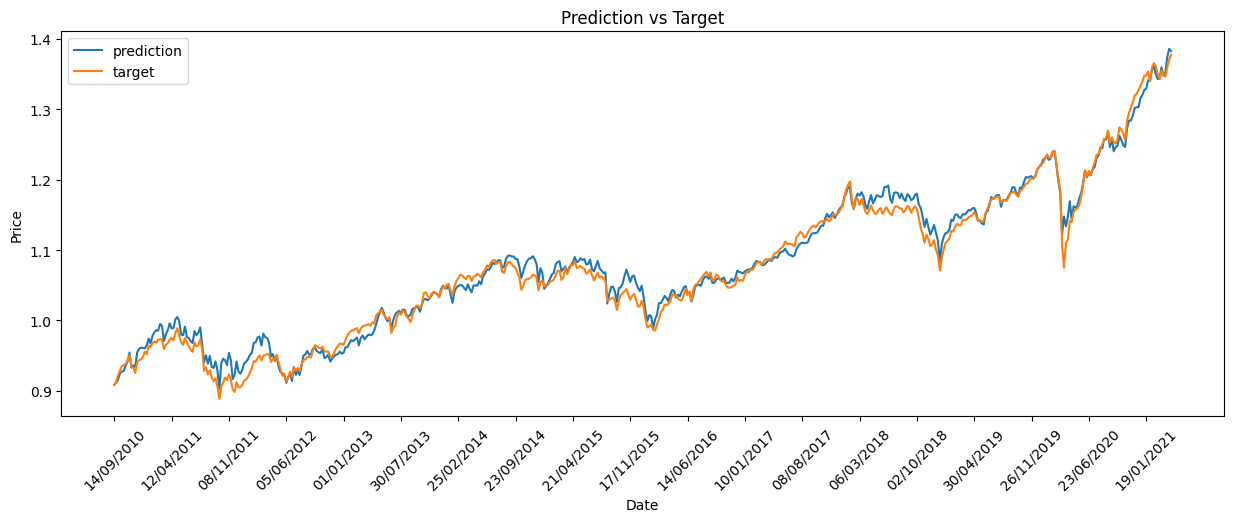

In [84]:
plt.figure(figsize=(15,5))
plt.plot(df['Date'][len(X)-len(y_pred_Enet)+1:], y_pred_Enet, label='prediction')
plt.plot(df['Date'][len(X)-len(y_pred_Enet)+1:], y_test_Enet, label='target')
plt.title('Prediction vs Target')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(df['Date'][len(X)-len(y_pred_Enet)+1::30], rotation=45)
plt.show()

We compute various metrics, to see how well the model is performing.

We use both statistical metrics, such as the MSE, and financial metrics, such as the Tracking Error and the Gross Exposure.

In [85]:
MSE_Enet = mean_squared_error(y_test_Enet, y_pred_Enet)
print('MSE:', MSE_Enet)

tracking_error_Enet = []
for i in range(len(y_pred_Enet)):
    tracking_error_Enet.append(y_test_Enet[i] - y_pred_Enet[i])

tracking_error_volatility_Enet = np.std(tracking_error_Enet)*np.sqrt(52)
print('Tracking Error Volatility:', tracking_error_volatility_Enet)

information_ratio_Enet = np.mean(tracking_error_Enet)/tracking_error_volatility_Enet
print('Information Ratio:', information_ratio_Enet)

turnover_Enet = []
d_weights_Enet = np.diff(weights_Enet, axis=0)
turnover_Enet = np.sum(np.abs(d_weights_Enet), axis=1) / 2

mean_annual_turnover_Enet = np.mean(turnover_Enet)*52
print('Mean Annual Turnover:', mean_annual_turnover_Enet)

tradingCosts = 0.0004
meanTradingCosts_Enet = mean_annual_turnover_Enet*tradingCosts
print('Mean Annual Trading Costs:', meanTradingCosts_Enet)

MSE: 0.00017752940619198307
Tracking Error Volatility: 0.08939277134643997
Information Ratio: -0.05463709255658482
Mean Annual Turnover: 0.23980070475637938
Mean Annual Trading Costs: 9.592028190255176e-05


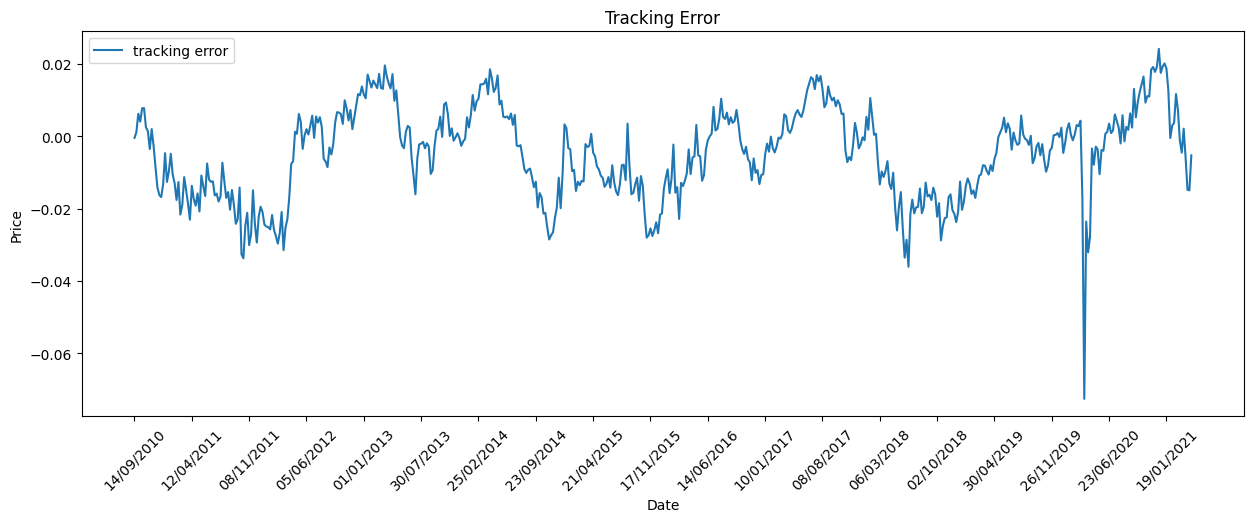

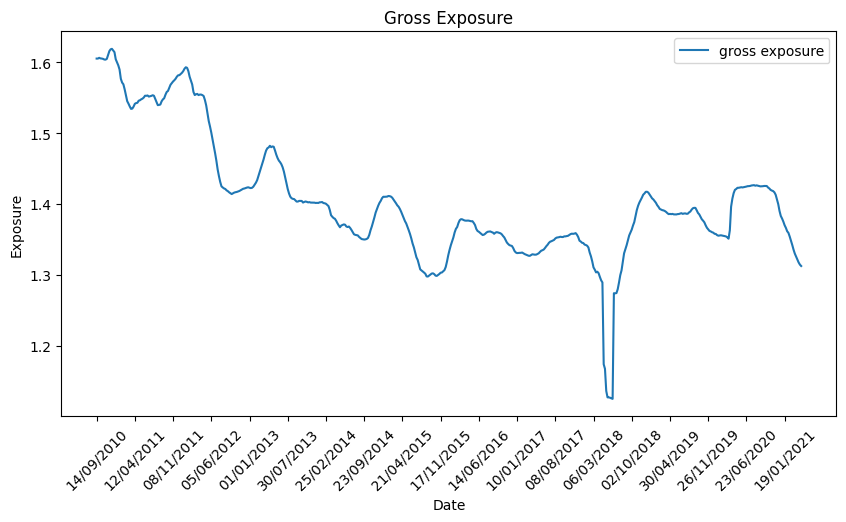

In [86]:
plt.figure(figsize=(15,5))
plt.plot(df['Date'][len(X)-len(y_pred_Enet)+1:], tracking_error_Enet, label='tracking error')
plt.title('Tracking Error')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(df['Date'][len(X)-len(y_pred_Enet)+1::30], rotation=45)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(df['Date'][len(X)-len(y_pred_Enet)+1:], gross_exposure_Enet+np.ones(np.shape(gross_exposure_Enet)), label='gross exposure')
plt.title('Gross Exposure')
plt.xlabel('Date')
plt.ylabel('Exposure')
plt.legend()
plt.xticks(df['Date'][len(X)-len(y_pred_Enet)+1::30], rotation=45)
plt.show()

In [87]:
y_pred_Enet = np.array(y_pred_Enet)
np.savetxt('y_pred_Enet.csv', y_pred_Enet, delimiter=',')

Model            MSE    Tracking Error Volatility    Information Ratio    Mean Annual Turnover    Mean Annual Trading Costs
-------  -----------  ---------------------------  -------------------  ----------------------  ---------------------------
Lasso    0.000959709                    0.175779            -0.108764                 0.720391                  0.000288156
PAR      0.00424049                     0.467084            -0.0143552                1.59086                   0.000636345
SGD      0.00519614                     0.460137            -0.0728772                0.409487                  0.000163795
Enet     0.000177529                    0.0893928           -0.0546371                0.239801                  9.59203e-05


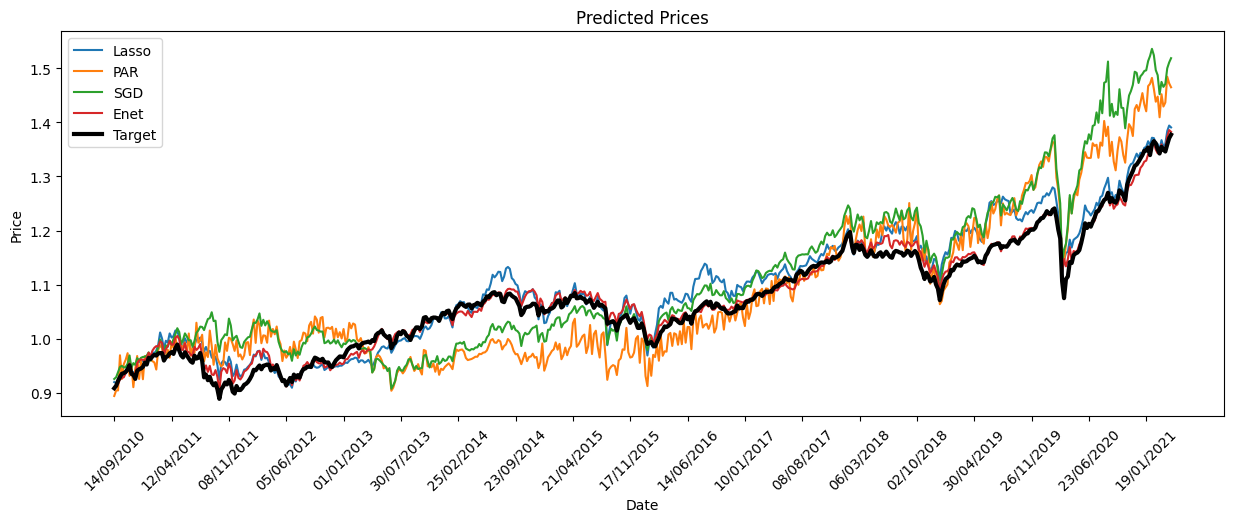

In [91]:
from tabulate import tabulate


table = [["Lasso", MSE_Lasso, tracking_error_volatility_Lasso, information_ratio_Lasso, mean_annual_turnover_Lasso, meanTradingCosts_Lasso],
            ["PAR", MSE_PAR, tracking_error_volatility_PAR, information_ratio_PAR, mean_annual_turnover_PAR, meanTradingCosts_PAR],
            ["SGD", MSE_SGD, tracking_error_volatility_SGD, information_ratio_SGD, mean_annual_turnover_SGD, meanTradingCosts_SGD],
            ["Enet", MSE_Enet, tracking_error_volatility_Enet, information_ratio_Enet, mean_annual_turnover_Enet, meanTradingCosts_Enet]]

print(tabulate(table, headers=["Model", "MSE", "Tracking Error Volatility", "Information Ratio", "Mean Annual Turnover", "Mean Annual Trading Costs", "Sharpe Ratio", "Maximum Drawdown"]))

plt.figure(figsize=(15,5))
plt.plot(df['Date'][len(X)-len(y_pred_Lasso)+1:], y_pred_Lasso, label='Lasso')
plt.plot(df['Date'][len(X)-len(y_pred_PAR)+1:], y_pred_PAR, label='PAR')
plt.plot(df['Date'][len(X)-len(y_pred_SGD)+1:], y_pred_SGD, label='SGD')
plt.plot(df['Date'][len(X)-len(y_pred_Enet)+1:], y_pred_Enet, label='Enet')
plt.plot(df['Date'][len(X)-len(y_test_Enet)+1:], y_test_Enet, label='Target', linewidth=3, color='black')
plt.title('Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(df['Date'][len(X)-len(y_pred_Enet)+1::30], rotation=45)
plt.show()

The best model is the **Elastic Net** with optimal hyperparameters.

### Feature Importance on the best model

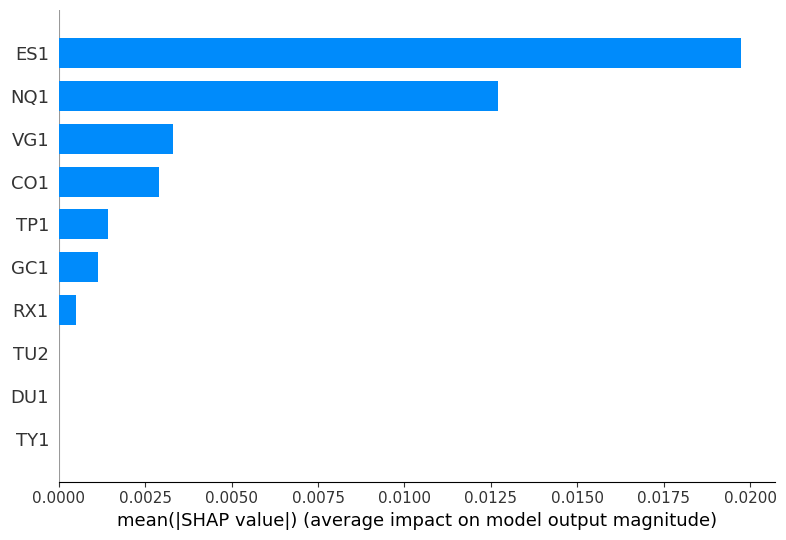

In [88]:
#do a feature importance analysis on the final model through shap values
import shap
explainer = shap.LinearExplainer(grid_search.best_estimator_, X[i-150:i])
shap_values = explainer.shap_values(X[i-150:i])

shap.summary_plot(shap_values, X[i-150:i], feature_names=X.columns, plot_type="bar")


This Feature Importance analysis tells us which features are the most important for the model.

We see that there are some variables that are not important at all, so we could remove them from the model without losing much in terms of efficiency.

Since the computational complexity of the model is not a problem, we will not remove them, but it is good to know that we could do it if we wanted to.

This removal could also be useful to make the model more interpretable, since it would be easier to explain to a client.

In [92]:
import pickle
filename = 'Enet.sav'
pickle.dump(grid_search.best_estimator_, open(filename, 'wb'))